# Library

In [44]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Conv2D, Dense,ReLU, Reshape, ZeroPadding2D, Conv2DTranspose, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from scipy.linalg import sqrtm

SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# Read Dataset

In [23]:
path_kirmizi = 'B_23/kirmizi'
path_siirt = 'B_23/siirt'

img_kirmizi = []
img_siirt = []

for root, dirs, files in os.walk(path_kirmizi):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_kirmizi.append(os.path.join(root, file))

for root, dirs, files in os.walk(path_siirt):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_siirt.append(os.path.join(root, file))

In [24]:
for dirpath, dirnames, filenames in os.walk("B_23"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'B_23'.
There are 0 directories and 616 images in 'B_23\kirmizi'.
There are 0 directories and 458 images in 'B_23\siirt'.


In [25]:
def display_sample(image_list, title_prefix="Images"):
    n = min(5, len(image_list))
    plt.figure(figsize=(10, 5))
    plt.suptitle(title_prefix, fontsize=14,y=0.75)

    for i in range(n):
        img_path = image_list[i]
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"Sample {i + 1}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

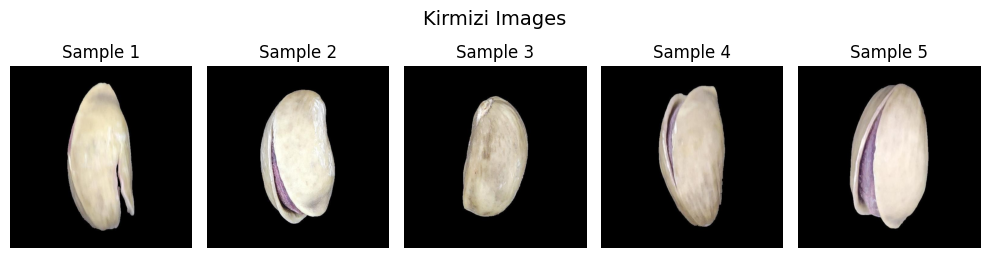

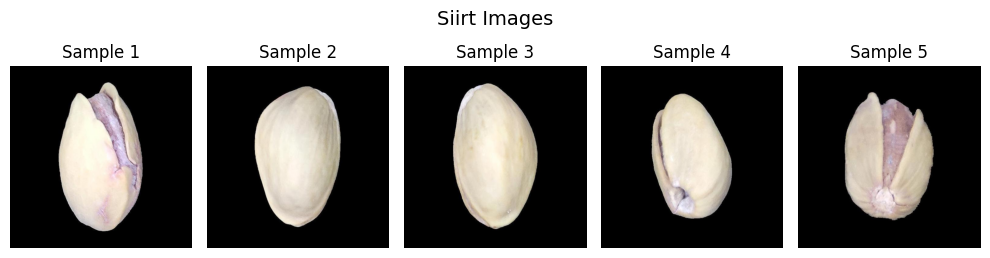

In [26]:
display_sample(img_kirmizi, title_prefix="Kirmizi Images")
display_sample(img_siirt, title_prefix="Siirt Images")

# Image Characteristics

In [27]:
dimensions = []
data_types = []
num_nChannels = []
img_all = img_kirmizi + img_siirt

for i, img_path in enumerate(img_all):
    img = Image.open(img_path).convert('RGB')
    img_array = np.array(img)
    
    dimensions.append(img_array.shape[:2])
    data_types.append(img_array.dtype)
    num_nChannels.append(img_array.shape[2] if img_array.ndim == 3 else 1)

In [28]:
unique_dimensions = set(dimensions)
print(f"All dimensions: {unique_dimensions}")
unique_data_types = set(data_types)
print(f"All data types: {unique_data_types}")
unique_nChannels = set(num_nChannels)
print(f"All nChannels: {unique_nChannels}")

All dimensions: {(600, 600)}
All data types: {dtype('uint8')}
All nChannels: {3}


# Resize and Add Noise


In [29]:
IMG_SIZE = (100, 100)
img_processed = []

for i, img_path in enumerate(img_all):
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(IMG_SIZE)
    img_array = np.array(img_resized)
    
    img_normalized = img_array.astype('float32') / 255.0
    img_processed.append(img_normalized)

img_processed = np.array(img_processed)

In [30]:
X_train, X_temp = train_test_split(img_processed, test_size=0.2, random_state=354)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=354)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(859, 100, 100, 3)
(107, 100, 100, 3)
(108, 100, 100, 3)


In [31]:
def addNoise(images, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, size=images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0., 1.)

x_train = addNoise(X_train)
x_val = addNoise(X_val)
x_test = addNoise(X_test)

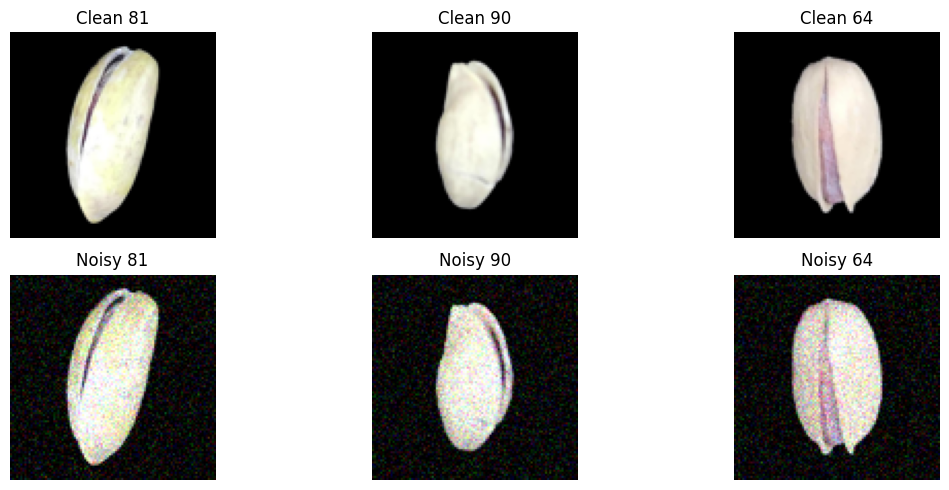

In [32]:
plt.figure(figsize=(12, 5))

for i in range(3):
    idx = np.random.randint(0, len(x_test))

    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Clean {idx}")
    plt.axis('off')

    plt.subplot(2, 3, i + 3 + 1)
    plt.imshow(x_test[idx])
    plt.title(f"Noisy {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [33]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(859, 100, 100, 3)
(107, 100, 100, 3)
(108, 100, 100, 3)


# GAN

In [34]:
noise_dim = 100
img_shape = (100, 100, 3)
def build_generator():
    model = Sequential()
    model.add(Dense(25*25*64, input_dim=noise_dim))
    model.add(Reshape((25, 25, 64)))  

    model.add(Conv2D(64, kernel_size=3, strides=1, padding='valid'))  
    model.add(ReLU())

    model.add(Conv2D(32, kernel_size=3, strides=1, padding='valid'))  
    model.add(ReLU())

    model.add(Conv2D(16, kernel_size=3, strides=1, padding='valid'))  
    model.add(ReLU())

    model.add(Conv2DTranspose(16, kernel_size=5, strides=5, padding='valid'))  
    model.add(ZeroPadding2D(((2,3),(2,3))))  
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))  

    noise = Input(shape=(noise_dim,))
    img = model(noise)
    return Model(noise, img)

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=3, strides=1, padding='valid', input_shape=img_shape))
    model.add(ReLU())

    model.add(Conv2D(32, kernel_size=3, strides=1, padding='valid'))
    model.add(ReLU())

    model.add(Conv2D(64, kernel_size=3, strides=1, padding='valid'))
    model.add(ReLU())

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

In [35]:
generator = build_generator()
discriminator = build_discriminator()
generator.summary()
discriminator.summary()


discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 100, 100, 3)    │     4,106,867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,106,867 (15.67 MB)

 Trainable params: 4,106,867 (15.67 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 1)              │       589,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 589,089 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
cross_entropy = BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(5e-5)

gan_train = (X_train * 2) - 1
gan_val = (X_val * 2) - 1
gan_test = (X_test * 2) - 1

nEpoch = 300
nBatch = 32

train_dataset = tf.data.Dataset.from_tensor_slices(gan_train).shuffle(len(gan_train)).batch(nBatch)

Epoch 1/300 --- Generator Loss: 0.7391 --- Discriminator Loss: 0.6869
Epoch 2/300 --- Generator Loss: 1.5800 --- Discriminator Loss: 0.2769
Epoch 3/300 --- Generator Loss: 3.8202 --- Discriminator Loss: 0.0283
Epoch 4/300 --- Generator Loss: 5.3825 --- Discriminator Loss: 0.0050
Epoch 5/300 --- Generator Loss: 6.0751 --- Discriminator Loss: 0.0025


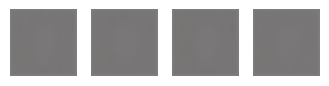

Epoch 6/300 --- Generator Loss: 5.7285 --- Discriminator Loss: 0.0056
Epoch 7/300 --- Generator Loss: 4.4374 --- Discriminator Loss: 0.0568
Epoch 8/300 --- Generator Loss: 5.6711 --- Discriminator Loss: 0.0258
Epoch 9/300 --- Generator Loss: 5.3984 --- Discriminator Loss: 0.0946
Epoch 10/300 --- Generator Loss: 4.4420 --- Discriminator Loss: 0.2885


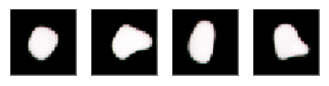

Epoch 11/300 --- Generator Loss: 4.9506 --- Discriminator Loss: 0.0650
Epoch 12/300 --- Generator Loss: 5.0233 --- Discriminator Loss: 0.0195
Epoch 13/300 --- Generator Loss: 5.0464 --- Discriminator Loss: 0.0171
Epoch 14/300 --- Generator Loss: 5.1062 --- Discriminator Loss: 0.0140
Epoch 15/300 --- Generator Loss: 5.3004 --- Discriminator Loss: 0.0111


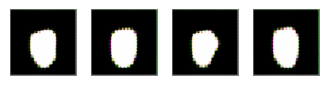

Epoch 16/300 --- Generator Loss: 5.4733 --- Discriminator Loss: 0.0090
Epoch 17/300 --- Generator Loss: 5.5596 --- Discriminator Loss: 0.0079
Epoch 18/300 --- Generator Loss: 5.7126 --- Discriminator Loss: 0.0072
Epoch 19/300 --- Generator Loss: 5.6919 --- Discriminator Loss: 0.0073
Epoch 20/300 --- Generator Loss: 5.6474 --- Discriminator Loss: 0.0076


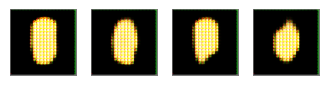

Epoch 21/300 --- Generator Loss: 5.8026 --- Discriminator Loss: 0.0065
Epoch 22/300 --- Generator Loss: 6.0741 --- Discriminator Loss: 0.0047
Epoch 23/300 --- Generator Loss: 5.9376 --- Discriminator Loss: 0.0055
Epoch 24/300 --- Generator Loss: 6.0684 --- Discriminator Loss: 0.0048
Epoch 25/300 --- Generator Loss: 6.2399 --- Discriminator Loss: 0.0040


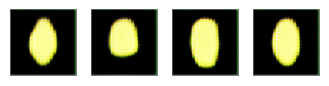

Epoch 26/300 --- Generator Loss: 6.3552 --- Discriminator Loss: 0.0036
Epoch 27/300 --- Generator Loss: 6.4617 --- Discriminator Loss: 0.0033
Epoch 28/300 --- Generator Loss: 6.5361 --- Discriminator Loss: 0.0031
Epoch 29/300 --- Generator Loss: 6.6232 --- Discriminator Loss: 0.0028
Epoch 30/300 --- Generator Loss: 6.6474 --- Discriminator Loss: 0.0027


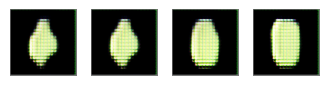

Epoch 31/300 --- Generator Loss: 6.5982 --- Discriminator Loss: 0.0027
Epoch 32/300 --- Generator Loss: 6.6228 --- Discriminator Loss: 0.0026
Epoch 33/300 --- Generator Loss: 6.7752 --- Discriminator Loss: 0.0023
Epoch 34/300 --- Generator Loss: 6.9207 --- Discriminator Loss: 0.0020
Epoch 35/300 --- Generator Loss: 7.0554 --- Discriminator Loss: 0.0018


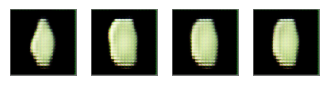

Epoch 36/300 --- Generator Loss: 7.1366 --- Discriminator Loss: 0.0016
Epoch 37/300 --- Generator Loss: 7.1961 --- Discriminator Loss: 0.0015
Epoch 38/300 --- Generator Loss: 7.1552 --- Discriminator Loss: 0.0016
Epoch 39/300 --- Generator Loss: 6.9399 --- Discriminator Loss: 0.0019
Epoch 40/300 --- Generator Loss: 6.9756 --- Discriminator Loss: 0.0019


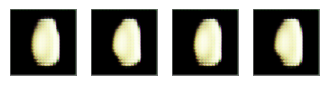

Epoch 41/300 --- Generator Loss: 7.1981 --- Discriminator Loss: 0.0015
Epoch 42/300 --- Generator Loss: 7.4045 --- Discriminator Loss: 0.0012
Epoch 43/300 --- Generator Loss: 7.5604 --- Discriminator Loss: 0.0011
Epoch 44/300 --- Generator Loss: 7.6893 --- Discriminator Loss: 0.0009
Epoch 45/300 --- Generator Loss: 7.8014 --- Discriminator Loss: 0.0008


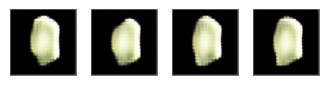

Epoch 46/300 --- Generator Loss: 7.9135 --- Discriminator Loss: 0.0007
Epoch 47/300 --- Generator Loss: 7.9936 --- Discriminator Loss: 0.0007
Epoch 48/300 --- Generator Loss: 8.0796 --- Discriminator Loss: 0.0006
Epoch 49/300 --- Generator Loss: 8.1050 --- Discriminator Loss: 0.0006
Epoch 50/300 --- Generator Loss: 8.0853 --- Discriminator Loss: 0.0006


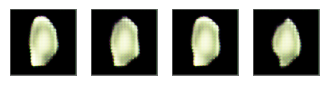

Epoch 51/300 --- Generator Loss: 7.8573 --- Discriminator Loss: 0.0008
Epoch 52/300 --- Generator Loss: 7.6781 --- Discriminator Loss: 0.0009
Epoch 53/300 --- Generator Loss: 7.7666 --- Discriminator Loss: 0.0009
Epoch 54/300 --- Generator Loss: 7.9062 --- Discriminator Loss: 0.0008
Epoch 55/300 --- Generator Loss: 8.1042 --- Discriminator Loss: 0.0006


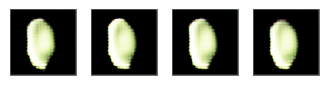

Epoch 56/300 --- Generator Loss: 8.2236 --- Discriminator Loss: 0.0005
Epoch 57/300 --- Generator Loss: 8.3756 --- Discriminator Loss: 0.0005
Epoch 58/300 --- Generator Loss: 8.4467 --- Discriminator Loss: 0.0004
Epoch 59/300 --- Generator Loss: 8.5674 --- Discriminator Loss: 0.0004
Epoch 60/300 --- Generator Loss: 8.6135 --- Discriminator Loss: 0.0004


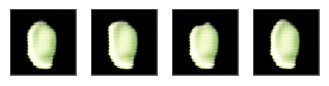

Epoch 61/300 --- Generator Loss: 8.6584 --- Discriminator Loss: 0.0004
Epoch 62/300 --- Generator Loss: 8.6812 --- Discriminator Loss: 0.0003
Epoch 63/300 --- Generator Loss: 8.5976 --- Discriminator Loss: 0.0004
Epoch 64/300 --- Generator Loss: 8.5675 --- Discriminator Loss: 0.0004
Epoch 65/300 --- Generator Loss: 8.5933 --- Discriminator Loss: 0.0004


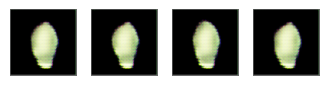

Epoch 66/300 --- Generator Loss: 8.6252 --- Discriminator Loss: 0.0004
Epoch 67/300 --- Generator Loss: 8.7232 --- Discriminator Loss: 0.0003
Epoch 68/300 --- Generator Loss: 8.7579 --- Discriminator Loss: 0.0003
Epoch 69/300 --- Generator Loss: 8.7329 --- Discriminator Loss: 0.0003
Epoch 70/300 --- Generator Loss: 8.8523 --- Discriminator Loss: 0.0003


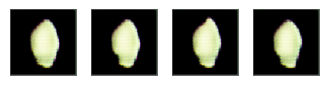

Epoch 71/300 --- Generator Loss: 8.8210 --- Discriminator Loss: 0.0003
Epoch 72/300 --- Generator Loss: 8.8900 --- Discriminator Loss: 0.0003
Epoch 73/300 --- Generator Loss: 8.9561 --- Discriminator Loss: 0.0003
Epoch 74/300 --- Generator Loss: 8.9798 --- Discriminator Loss: 0.0003
Epoch 75/300 --- Generator Loss: 9.0228 --- Discriminator Loss: 0.0002


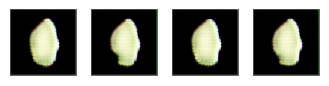

Epoch 76/300 --- Generator Loss: 9.0648 --- Discriminator Loss: 0.0002
Epoch 77/300 --- Generator Loss: 9.0895 --- Discriminator Loss: 0.0002
Epoch 78/300 --- Generator Loss: 9.1480 --- Discriminator Loss: 0.0002
Epoch 79/300 --- Generator Loss: 9.2015 --- Discriminator Loss: 0.0002
Epoch 80/300 --- Generator Loss: 9.2424 --- Discriminator Loss: 0.0002


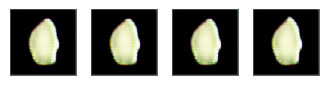

Epoch 81/300 --- Generator Loss: 9.2983 --- Discriminator Loss: 0.0002
Epoch 82/300 --- Generator Loss: 9.3267 --- Discriminator Loss: 0.0002
Epoch 83/300 --- Generator Loss: 9.3275 --- Discriminator Loss: 0.0002
Epoch 84/300 --- Generator Loss: 9.3129 --- Discriminator Loss: 0.0002
Epoch 85/300 --- Generator Loss: 9.2865 --- Discriminator Loss: 0.0002


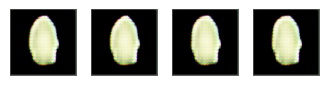

Epoch 86/300 --- Generator Loss: 9.3192 --- Discriminator Loss: 0.0002
Epoch 87/300 --- Generator Loss: 9.3787 --- Discriminator Loss: 0.0002
Epoch 88/300 --- Generator Loss: 9.3937 --- Discriminator Loss: 0.0002
Epoch 89/300 --- Generator Loss: 9.4148 --- Discriminator Loss: 0.0002
Epoch 90/300 --- Generator Loss: 9.4316 --- Discriminator Loss: 0.0002


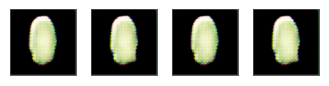

Epoch 91/300 --- Generator Loss: 9.3901 --- Discriminator Loss: 0.0002
Epoch 92/300 --- Generator Loss: 9.4082 --- Discriminator Loss: 0.0002
Epoch 93/300 --- Generator Loss: 9.4419 --- Discriminator Loss: 0.0002
Epoch 94/300 --- Generator Loss: 9.5303 --- Discriminator Loss: 0.0001
Epoch 95/300 --- Generator Loss: 9.5730 --- Discriminator Loss: 0.0001


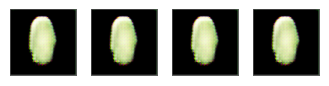

Epoch 96/300 --- Generator Loss: 9.6195 --- Discriminator Loss: 0.0001
Epoch 97/300 --- Generator Loss: 9.6731 --- Discriminator Loss: 0.0001
Epoch 98/300 --- Generator Loss: 9.7118 --- Discriminator Loss: 0.0001
Epoch 99/300 --- Generator Loss: 9.7529 --- Discriminator Loss: 0.0001
Epoch 100/300 --- Generator Loss: 9.8069 --- Discriminator Loss: 0.0001


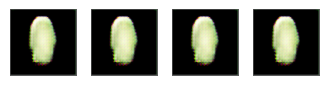

Epoch 101/300 --- Generator Loss: 9.8294 --- Discriminator Loss: 0.0001
Epoch 102/300 --- Generator Loss: 9.8745 --- Discriminator Loss: 0.0001
Epoch 103/300 --- Generator Loss: 9.9165 --- Discriminator Loss: 0.0001
Epoch 104/300 --- Generator Loss: 9.9318 --- Discriminator Loss: 0.0001
Epoch 105/300 --- Generator Loss: 9.9743 --- Discriminator Loss: 0.0001


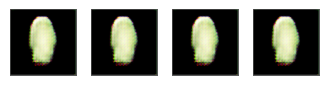

Epoch 106/300 --- Generator Loss: 9.9869 --- Discriminator Loss: 0.0001
Epoch 107/300 --- Generator Loss: 10.0379 --- Discriminator Loss: 0.0001
Epoch 108/300 --- Generator Loss: 10.0682 --- Discriminator Loss: 0.0001
Epoch 109/300 --- Generator Loss: 10.0605 --- Discriminator Loss: 0.0001
Epoch 110/300 --- Generator Loss: 10.0994 --- Discriminator Loss: 0.0001


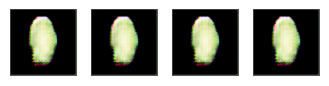

Epoch 111/300 --- Generator Loss: 10.1094 --- Discriminator Loss: 0.0001
Epoch 112/300 --- Generator Loss: 10.1286 --- Discriminator Loss: 0.0001
Epoch 113/300 --- Generator Loss: 10.1513 --- Discriminator Loss: 0.0001
Epoch 114/300 --- Generator Loss: 10.1726 --- Discriminator Loss: 0.0001
Epoch 115/300 --- Generator Loss: 10.0650 --- Discriminator Loss: 0.0001


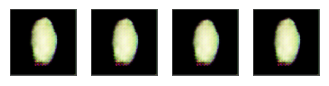

Epoch 116/300 --- Generator Loss: 9.9638 --- Discriminator Loss: 0.0001
Epoch 117/300 --- Generator Loss: 9.9787 --- Discriminator Loss: 0.0001
Epoch 118/300 --- Generator Loss: 9.9898 --- Discriminator Loss: 0.0001
Epoch 119/300 --- Generator Loss: 10.0278 --- Discriminator Loss: 0.0001
Epoch 120/300 --- Generator Loss: 10.0658 --- Discriminator Loss: 0.0001


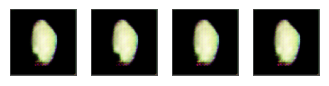

Epoch 121/300 --- Generator Loss: 10.1061 --- Discriminator Loss: 0.0001
Epoch 122/300 --- Generator Loss: 10.1413 --- Discriminator Loss: 0.0001
Epoch 123/300 --- Generator Loss: 10.1720 --- Discriminator Loss: 0.0001
Epoch 124/300 --- Generator Loss: 10.2060 --- Discriminator Loss: 0.0001
Epoch 125/300 --- Generator Loss: 10.2557 --- Discriminator Loss: 0.0001


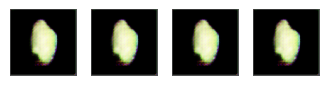

Epoch 126/300 --- Generator Loss: 10.2828 --- Discriminator Loss: 0.0001
Epoch 127/300 --- Generator Loss: 10.3245 --- Discriminator Loss: 0.0001
Epoch 128/300 --- Generator Loss: 10.3482 --- Discriminator Loss: 0.0001
Epoch 129/300 --- Generator Loss: 10.3843 --- Discriminator Loss: 0.0001
Epoch 130/300 --- Generator Loss: 10.3584 --- Discriminator Loss: 0.0001


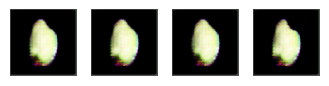

Epoch 131/300 --- Generator Loss: 10.1550 --- Discriminator Loss: 0.0001
Epoch 132/300 --- Generator Loss: 9.9264 --- Discriminator Loss: 0.0001
Epoch 133/300 --- Generator Loss: 9.9875 --- Discriminator Loss: 0.0001
Epoch 134/300 --- Generator Loss: 10.0498 --- Discriminator Loss: 0.0001
Epoch 135/300 --- Generator Loss: 10.1826 --- Discriminator Loss: 0.0001


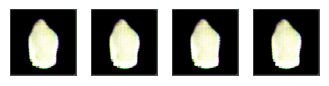

Epoch 136/300 --- Generator Loss: 10.2618 --- Discriminator Loss: 0.0001
Epoch 137/300 --- Generator Loss: 10.3485 --- Discriminator Loss: 0.0001
Epoch 138/300 --- Generator Loss: 10.4158 --- Discriminator Loss: 0.0001
Epoch 139/300 --- Generator Loss: 10.5049 --- Discriminator Loss: 0.0001
Epoch 140/300 --- Generator Loss: 10.5323 --- Discriminator Loss: 0.0001


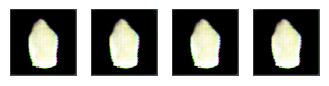

Epoch 141/300 --- Generator Loss: 10.6055 --- Discriminator Loss: 0.0001
Epoch 142/300 --- Generator Loss: 10.6608 --- Discriminator Loss: 0.0000
Epoch 143/300 --- Generator Loss: 10.6715 --- Discriminator Loss: 0.0000
Epoch 144/300 --- Generator Loss: 10.6620 --- Discriminator Loss: 0.0000
Epoch 145/300 --- Generator Loss: 10.6498 --- Discriminator Loss: 0.0000


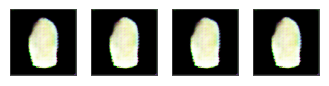

Epoch 146/300 --- Generator Loss: 10.6461 --- Discriminator Loss: 0.0000
Epoch 147/300 --- Generator Loss: 10.6005 --- Discriminator Loss: 0.0001
Epoch 148/300 --- Generator Loss: 10.4336 --- Discriminator Loss: 0.0001
Epoch 149/300 --- Generator Loss: 10.3865 --- Discriminator Loss: 0.0001
Epoch 150/300 --- Generator Loss: 10.4472 --- Discriminator Loss: 0.0001


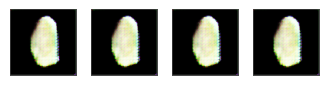

Epoch 151/300 --- Generator Loss: 10.4846 --- Discriminator Loss: 0.0001
Epoch 152/300 --- Generator Loss: 10.5238 --- Discriminator Loss: 0.0001
Epoch 153/300 --- Generator Loss: 10.5728 --- Discriminator Loss: 0.0001
Epoch 154/300 --- Generator Loss: 10.6427 --- Discriminator Loss: 0.0000
Epoch 155/300 --- Generator Loss: 10.6702 --- Discriminator Loss: 0.0000


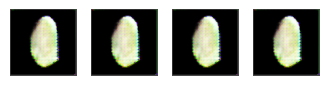

Epoch 156/300 --- Generator Loss: 10.6880 --- Discriminator Loss: 0.0000
Epoch 157/300 --- Generator Loss: 10.7412 --- Discriminator Loss: 0.0000
Epoch 158/300 --- Generator Loss: 10.7954 --- Discriminator Loss: 0.0000
Epoch 159/300 --- Generator Loss: 10.7945 --- Discriminator Loss: 0.0000
Epoch 160/300 --- Generator Loss: 10.8110 --- Discriminator Loss: 0.0000


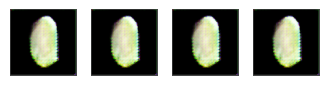

Epoch 161/300 --- Generator Loss: 10.8506 --- Discriminator Loss: 0.0000
Epoch 162/300 --- Generator Loss: 10.8521 --- Discriminator Loss: 0.0000
Epoch 163/300 --- Generator Loss: 10.8741 --- Discriminator Loss: 0.0000
Epoch 164/300 --- Generator Loss: 10.8240 --- Discriminator Loss: 0.0000
Epoch 165/300 --- Generator Loss: 10.8151 --- Discriminator Loss: 0.0000


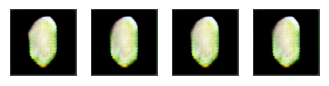

Epoch 166/300 --- Generator Loss: 10.7103 --- Discriminator Loss: 0.0000
Epoch 167/300 --- Generator Loss: 10.6521 --- Discriminator Loss: 0.0000
Epoch 168/300 --- Generator Loss: 10.6662 --- Discriminator Loss: 0.0000
Epoch 169/300 --- Generator Loss: 10.6759 --- Discriminator Loss: 0.0000
Epoch 170/300 --- Generator Loss: 10.7448 --- Discriminator Loss: 0.0000


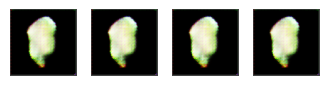

Epoch 171/300 --- Generator Loss: 10.7418 --- Discriminator Loss: 0.0000
Epoch 172/300 --- Generator Loss: 10.7039 --- Discriminator Loss: 0.0000
Epoch 173/300 --- Generator Loss: 10.6696 --- Discriminator Loss: 0.0000
Epoch 174/300 --- Generator Loss: 10.7426 --- Discriminator Loss: 0.0000
Epoch 175/300 --- Generator Loss: 10.8307 --- Discriminator Loss: 0.0000


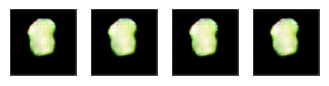

Epoch 176/300 --- Generator Loss: 10.8929 --- Discriminator Loss: 0.0000
Epoch 177/300 --- Generator Loss: 10.9813 --- Discriminator Loss: 0.0000
Epoch 178/300 --- Generator Loss: 11.0288 --- Discriminator Loss: 0.0000
Epoch 179/300 --- Generator Loss: 11.1071 --- Discriminator Loss: 0.0000
Epoch 180/300 --- Generator Loss: 11.1639 --- Discriminator Loss: 0.0000


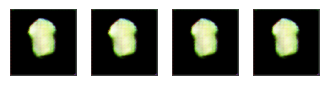

Epoch 181/300 --- Generator Loss: 11.1648 --- Discriminator Loss: 0.0000
Epoch 182/300 --- Generator Loss: 11.1981 --- Discriminator Loss: 0.0000
Epoch 183/300 --- Generator Loss: 11.2073 --- Discriminator Loss: 0.0000
Epoch 184/300 --- Generator Loss: 11.2221 --- Discriminator Loss: 0.0000
Epoch 185/300 --- Generator Loss: 11.2727 --- Discriminator Loss: 0.0000


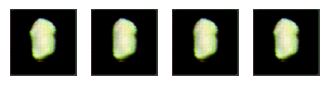

Epoch 186/300 --- Generator Loss: 11.2804 --- Discriminator Loss: 0.0000
Epoch 187/300 --- Generator Loss: 11.2614 --- Discriminator Loss: 0.0000
Epoch 188/300 --- Generator Loss: 11.1360 --- Discriminator Loss: 0.0000
Epoch 189/300 --- Generator Loss: 11.0561 --- Discriminator Loss: 0.0000
Epoch 190/300 --- Generator Loss: 10.9415 --- Discriminator Loss: 0.0000


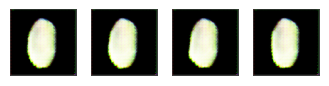

Epoch 191/300 --- Generator Loss: 10.8086 --- Discriminator Loss: 0.0000
Epoch 192/300 --- Generator Loss: 10.6178 --- Discriminator Loss: 0.0000
Epoch 193/300 --- Generator Loss: 10.5772 --- Discriminator Loss: 0.0001
Epoch 194/300 --- Generator Loss: 10.7258 --- Discriminator Loss: 0.0000
Epoch 195/300 --- Generator Loss: 10.8599 --- Discriminator Loss: 0.0000


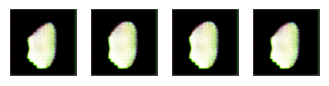

Epoch 196/300 --- Generator Loss: 10.9034 --- Discriminator Loss: 0.0000
Epoch 197/300 --- Generator Loss: 10.9005 --- Discriminator Loss: 0.0000
Epoch 198/300 --- Generator Loss: 10.8128 --- Discriminator Loss: 0.0000
Epoch 199/300 --- Generator Loss: 10.8814 --- Discriminator Loss: 0.0000
Epoch 200/300 --- Generator Loss: 10.9825 --- Discriminator Loss: 0.0000


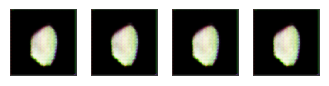

Epoch 201/300 --- Generator Loss: 11.0480 --- Discriminator Loss: 0.0000
Epoch 202/300 --- Generator Loss: 11.1455 --- Discriminator Loss: 0.0000
Epoch 203/300 --- Generator Loss: 11.1528 --- Discriminator Loss: 0.0000
Epoch 204/300 --- Generator Loss: 11.1895 --- Discriminator Loss: 0.0000
Epoch 205/300 --- Generator Loss: 11.2379 --- Discriminator Loss: 0.0000


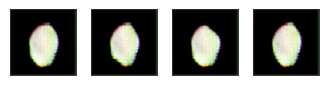

Epoch 206/300 --- Generator Loss: 11.2500 --- Discriminator Loss: 0.0000
Epoch 207/300 --- Generator Loss: 11.2756 --- Discriminator Loss: 0.0000
Epoch 208/300 --- Generator Loss: 11.2690 --- Discriminator Loss: 0.0000
Epoch 209/300 --- Generator Loss: 11.2781 --- Discriminator Loss: 0.0000
Epoch 210/300 --- Generator Loss: 11.3057 --- Discriminator Loss: 0.0000


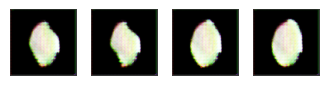

Epoch 211/300 --- Generator Loss: 11.3329 --- Discriminator Loss: 0.0000
Epoch 212/300 --- Generator Loss: 11.3427 --- Discriminator Loss: 0.0000
Epoch 213/300 --- Generator Loss: 11.3629 --- Discriminator Loss: 0.0000
Epoch 214/300 --- Generator Loss: 11.3690 --- Discriminator Loss: 0.0000
Epoch 215/300 --- Generator Loss: 11.3868 --- Discriminator Loss: 0.0000


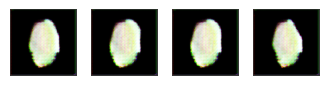

Epoch 216/300 --- Generator Loss: 11.4098 --- Discriminator Loss: 0.0000
Epoch 217/300 --- Generator Loss: 11.4128 --- Discriminator Loss: 0.0000
Epoch 218/300 --- Generator Loss: 11.4510 --- Discriminator Loss: 0.0000
Epoch 219/300 --- Generator Loss: 11.4513 --- Discriminator Loss: 0.0000
Epoch 220/300 --- Generator Loss: 11.3808 --- Discriminator Loss: 0.0000


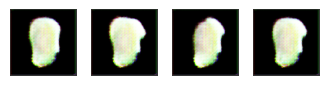

Epoch 221/300 --- Generator Loss: 11.3220 --- Discriminator Loss: 0.0000
Epoch 222/300 --- Generator Loss: 11.3800 --- Discriminator Loss: 0.0000
Epoch 223/300 --- Generator Loss: 11.4324 --- Discriminator Loss: 0.0000
Epoch 224/300 --- Generator Loss: 11.4650 --- Discriminator Loss: 0.0000
Epoch 225/300 --- Generator Loss: 11.5876 --- Discriminator Loss: 0.0000


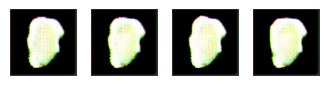

Epoch 226/300 --- Generator Loss: 11.6796 --- Discriminator Loss: 0.0000
Epoch 227/300 --- Generator Loss: 11.7420 --- Discriminator Loss: 0.0000
Epoch 228/300 --- Generator Loss: 11.7620 --- Discriminator Loss: 0.0000
Epoch 229/300 --- Generator Loss: 11.6953 --- Discriminator Loss: 0.0000
Epoch 230/300 --- Generator Loss: 11.3200 --- Discriminator Loss: 0.0000


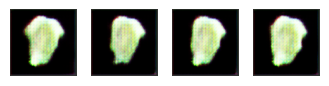

Epoch 231/300 --- Generator Loss: 9.4662 --- Discriminator Loss: 0.0009
Epoch 232/300 --- Generator Loss: 7.9586 --- Discriminator Loss: 0.3581
Epoch 233/300 --- Generator Loss: 2.7603 --- Discriminator Loss: 0.8425
Epoch 234/300 --- Generator Loss: 3.9559 --- Discriminator Loss: 0.1901
Epoch 235/300 --- Generator Loss: 3.9505 --- Discriminator Loss: 0.0934


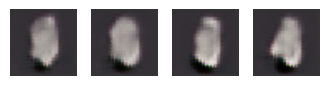

Epoch 236/300 --- Generator Loss: 4.8041 --- Discriminator Loss: 0.0228
Epoch 237/300 --- Generator Loss: 4.8307 --- Discriminator Loss: 0.0191
Epoch 238/300 --- Generator Loss: 4.6791 --- Discriminator Loss: 0.0191
Epoch 239/300 --- Generator Loss: 4.8376 --- Discriminator Loss: 0.0177
Epoch 240/300 --- Generator Loss: 5.2577 --- Discriminator Loss: 0.0121


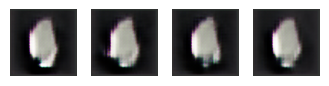

Epoch 241/300 --- Generator Loss: 5.6157 --- Discriminator Loss: 0.0088
Epoch 242/300 --- Generator Loss: 5.8356 --- Discriminator Loss: 0.0076
Epoch 243/300 --- Generator Loss: 5.9596 --- Discriminator Loss: 0.0068
Epoch 244/300 --- Generator Loss: 5.8396 --- Discriminator Loss: 0.0067
Epoch 245/300 --- Generator Loss: 5.7052 --- Discriminator Loss: 0.0069


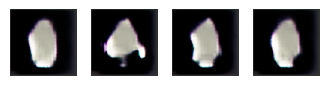

Epoch 246/300 --- Generator Loss: 5.8661 --- Discriminator Loss: 0.0063
Epoch 247/300 --- Generator Loss: 5.9418 --- Discriminator Loss: 0.0054
Epoch 248/300 --- Generator Loss: 5.9815 --- Discriminator Loss: 0.0052
Epoch 249/300 --- Generator Loss: 6.0382 --- Discriminator Loss: 0.0049
Epoch 250/300 --- Generator Loss: 6.1060 --- Discriminator Loss: 0.0044


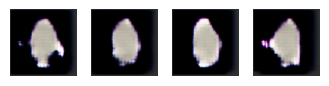

Epoch 251/300 --- Generator Loss: 6.2036 --- Discriminator Loss: 0.0041
Epoch 252/300 --- Generator Loss: 6.2898 --- Discriminator Loss: 0.0039
Epoch 253/300 --- Generator Loss: 6.3412 --- Discriminator Loss: 0.0036
Epoch 254/300 --- Generator Loss: 6.4134 --- Discriminator Loss: 0.0033
Epoch 255/300 --- Generator Loss: 6.4403 --- Discriminator Loss: 0.0033


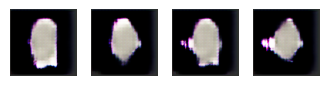

Epoch 256/300 --- Generator Loss: 6.4826 --- Discriminator Loss: 0.0032
Epoch 257/300 --- Generator Loss: 6.4815 --- Discriminator Loss: 0.0032
Epoch 258/300 --- Generator Loss: 6.5382 --- Discriminator Loss: 0.0031
Epoch 259/300 --- Generator Loss: 6.5801 --- Discriminator Loss: 0.0030
Epoch 260/300 --- Generator Loss: 6.6039 --- Discriminator Loss: 0.0028


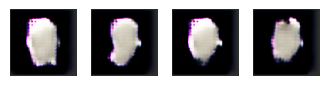

Epoch 261/300 --- Generator Loss: 6.6581 --- Discriminator Loss: 0.0027
Epoch 262/300 --- Generator Loss: 6.7609 --- Discriminator Loss: 0.0025
Epoch 263/300 --- Generator Loss: 6.8014 --- Discriminator Loss: 0.0023
Epoch 264/300 --- Generator Loss: 6.8953 --- Discriminator Loss: 0.0020
Epoch 265/300 --- Generator Loss: 7.0012 --- Discriminator Loss: 0.0019


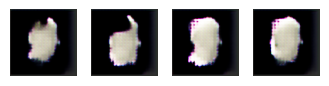

Epoch 266/300 --- Generator Loss: 7.0717 --- Discriminator Loss: 0.0017
Epoch 267/300 --- Generator Loss: 7.1071 --- Discriminator Loss: 0.0016
Epoch 268/300 --- Generator Loss: 7.2010 --- Discriminator Loss: 0.0016
Epoch 269/300 --- Generator Loss: 7.1652 --- Discriminator Loss: 0.0015
Epoch 270/300 --- Generator Loss: 7.2671 --- Discriminator Loss: 0.0015


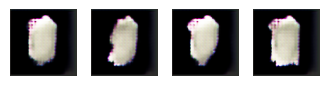

Epoch 271/300 --- Generator Loss: 7.2576 --- Discriminator Loss: 0.0014
Epoch 272/300 --- Generator Loss: 7.2958 --- Discriminator Loss: 0.0014
Epoch 273/300 --- Generator Loss: 7.3254 --- Discriminator Loss: 0.0014
Epoch 274/300 --- Generator Loss: 7.2361 --- Discriminator Loss: 0.0015
Epoch 275/300 --- Generator Loss: 7.1999 --- Discriminator Loss: 0.0015


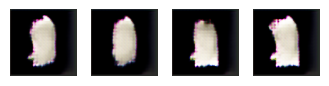

Epoch 276/300 --- Generator Loss: 7.2209 --- Discriminator Loss: 0.0015
Epoch 277/300 --- Generator Loss: 7.2205 --- Discriminator Loss: 0.0015
Epoch 278/300 --- Generator Loss: 7.2360 --- Discriminator Loss: 0.0014
Epoch 279/300 --- Generator Loss: 7.2735 --- Discriminator Loss: 0.0014
Epoch 280/300 --- Generator Loss: 7.2844 --- Discriminator Loss: 0.0014


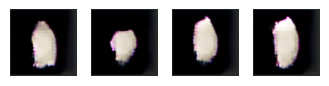

Epoch 281/300 --- Generator Loss: 7.2657 --- Discriminator Loss: 0.0014
Epoch 282/300 --- Generator Loss: 7.2858 --- Discriminator Loss: 0.0014
Epoch 283/300 --- Generator Loss: 7.2440 --- Discriminator Loss: 0.0014
Epoch 284/300 --- Generator Loss: 7.2244 --- Discriminator Loss: 0.0015
Epoch 285/300 --- Generator Loss: 7.2307 --- Discriminator Loss: 0.0014


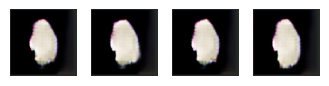

Epoch 286/300 --- Generator Loss: 7.2448 --- Discriminator Loss: 0.0014
Epoch 287/300 --- Generator Loss: 7.2434 --- Discriminator Loss: 0.0014
Epoch 288/300 --- Generator Loss: 7.2127 --- Discriminator Loss: 0.0015
Epoch 289/300 --- Generator Loss: 7.2261 --- Discriminator Loss: 0.0015
Epoch 290/300 --- Generator Loss: 7.2515 --- Discriminator Loss: 0.0015


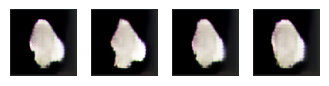

Epoch 291/300 --- Generator Loss: 7.3188 --- Discriminator Loss: 0.0013
Epoch 292/300 --- Generator Loss: 7.3727 --- Discriminator Loss: 0.0012
Epoch 293/300 --- Generator Loss: 7.4105 --- Discriminator Loss: 0.0012
Epoch 294/300 --- Generator Loss: 7.4622 --- Discriminator Loss: 0.0011
Epoch 295/300 --- Generator Loss: 7.4777 --- Discriminator Loss: 0.0012


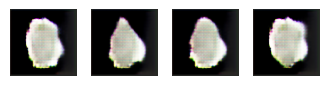

Epoch 296/300 --- Generator Loss: 7.3771 --- Discriminator Loss: 0.0013
Epoch 297/300 --- Generator Loss: 7.2771 --- Discriminator Loss: 0.0014
Epoch 298/300 --- Generator Loss: 7.3026 --- Discriminator Loss: 0.0013
Epoch 299/300 --- Generator Loss: 7.4091 --- Discriminator Loss: 0.0012
Epoch 300/300 --- Generator Loss: 7.5128 --- Discriminator Loss: 0.0011


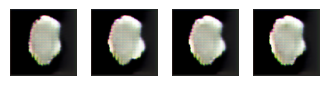

In [37]:
for epoch in range(nEpoch):
    gen_losses = []
    disc_losses = []
    
    for image_batch in train_dataset:
        noise = tf.random.normal([image_batch.shape[0], 100])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(image_batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            g_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        gen_losses.append(g_loss)
        disc_losses.append(disc_loss)
    
    avg_gen_loss = tf.reduce_mean(gen_losses)
    avg_disc_loss = tf.reduce_mean(disc_losses)
    
    print(f"Epoch {epoch+1}/{nEpoch} --- Generator Loss: {avg_gen_loss:.4f} --- Discriminator Loss: {avg_disc_loss:.4f}")

    if (epoch + 1) % 5 == 0:
        seed = tf.random.normal([4, 100])
        predictions = generator(seed, training=False)
        fig = plt.figure(figsize=(4,4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
            plt.axis('off')
        plt.show()

# Modified GAN

In [38]:
def build_generator_mod():
    model = Sequential()
    model.add(Dense(13 * 13 * 256, input_dim=noise_dim))
    model.add(Reshape((13, 13, 256)))  # Dimensi awal

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))  # 26x26
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))  # 52x52
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'))  # 104x104
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # Potong ke 100x100 dengan crop atau padding
    model.add(tf.keras.layers.Cropping2D(((2,2), (2,2))))  # dari 104x104 → 100x100

    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

    noise = Input(shape=(noise_dim,))
    img = model(noise)
    return Model(noise, img)

def build_discriminator_mod():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    model.add(LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

Epoch 1/300 --- Generator Loss: 0.5283 --- Discriminator Loss: 1.5127
Epoch 2/300 --- Generator Loss: 0.3616 --- Discriminator Loss: 1.6668
Epoch 3/300 --- Generator Loss: 0.2564 --- Discriminator Loss: 1.9307
Epoch 4/300 --- Generator Loss: 0.1931 --- Discriminator Loss: 2.1730
Epoch 5/300 --- Generator Loss: 0.1601 --- Discriminator Loss: 2.3526


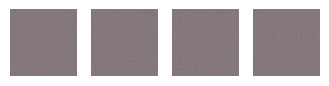

Epoch 6/300 --- Generator Loss: 0.1448 --- Discriminator Loss: 2.4452
Epoch 7/300 --- Generator Loss: 0.1380 --- Discriminator Loss: 2.4888
Epoch 8/300 --- Generator Loss: 0.1382 --- Discriminator Loss: 2.4841
Epoch 9/300 --- Generator Loss: 0.1412 --- Discriminator Loss: 2.4602
Epoch 10/300 --- Generator Loss: 0.1466 --- Discriminator Loss: 2.4407


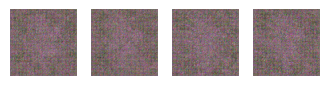

Epoch 11/300 --- Generator Loss: 0.1524 --- Discriminator Loss: 2.4189
Epoch 12/300 --- Generator Loss: 0.1638 --- Discriminator Loss: 2.3933
Epoch 13/300 --- Generator Loss: 0.1826 --- Discriminator Loss: 2.3357
Epoch 14/300 --- Generator Loss: 0.2026 --- Discriminator Loss: 2.2784
Epoch 15/300 --- Generator Loss: 0.2259 --- Discriminator Loss: 2.2039


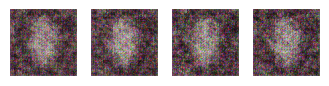

Epoch 16/300 --- Generator Loss: 0.2504 --- Discriminator Loss: 2.1346
Epoch 17/300 --- Generator Loss: 0.2812 --- Discriminator Loss: 2.0551
Epoch 18/300 --- Generator Loss: 0.3121 --- Discriminator Loss: 1.9795
Epoch 19/300 --- Generator Loss: 0.3442 --- Discriminator Loss: 1.9222
Epoch 20/300 --- Generator Loss: 0.3748 --- Discriminator Loss: 1.8558


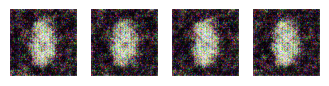

Epoch 21/300 --- Generator Loss: 0.4059 --- Discriminator Loss: 1.8039
Epoch 22/300 --- Generator Loss: 0.4309 --- Discriminator Loss: 1.7698
Epoch 23/300 --- Generator Loss: 0.4492 --- Discriminator Loss: 1.7343
Epoch 24/300 --- Generator Loss: 0.4722 --- Discriminator Loss: 1.7007
Epoch 25/300 --- Generator Loss: 0.4855 --- Discriminator Loss: 1.6802


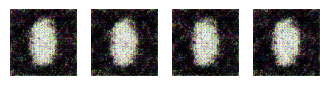

Epoch 26/300 --- Generator Loss: 0.4967 --- Discriminator Loss: 1.6638
Epoch 27/300 --- Generator Loss: 0.5049 --- Discriminator Loss: 1.6463
Epoch 28/300 --- Generator Loss: 0.5160 --- Discriminator Loss: 1.6241
Epoch 29/300 --- Generator Loss: 0.5241 --- Discriminator Loss: 1.6135
Epoch 30/300 --- Generator Loss: 0.5363 --- Discriminator Loss: 1.5964


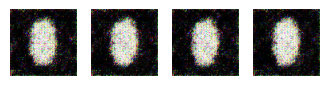

Epoch 31/300 --- Generator Loss: 0.5394 --- Discriminator Loss: 1.5942
Epoch 32/300 --- Generator Loss: 0.5436 --- Discriminator Loss: 1.5837
Epoch 33/300 --- Generator Loss: 0.5537 --- Discriminator Loss: 1.5754
Epoch 34/300 --- Generator Loss: 0.5558 --- Discriminator Loss: 1.5680
Epoch 35/300 --- Generator Loss: 0.5643 --- Discriminator Loss: 1.5591


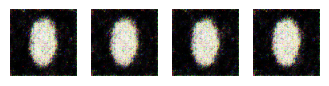

Epoch 36/300 --- Generator Loss: 0.5689 --- Discriminator Loss: 1.5540
Epoch 37/300 --- Generator Loss: 0.5766 --- Discriminator Loss: 1.5400
Epoch 38/300 --- Generator Loss: 0.5766 --- Discriminator Loss: 1.5450
Epoch 39/300 --- Generator Loss: 0.5839 --- Discriminator Loss: 1.5338
Epoch 40/300 --- Generator Loss: 0.5887 --- Discriminator Loss: 1.5306


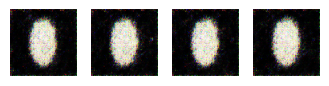

Epoch 41/300 --- Generator Loss: 0.5914 --- Discriminator Loss: 1.5232
Epoch 42/300 --- Generator Loss: 0.5950 --- Discriminator Loss: 1.5236
Epoch 43/300 --- Generator Loss: 0.5968 --- Discriminator Loss: 1.5177
Epoch 44/300 --- Generator Loss: 0.6060 --- Discriminator Loss: 1.5096
Epoch 45/300 --- Generator Loss: 0.6049 --- Discriminator Loss: 1.5056


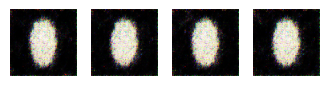

Epoch 46/300 --- Generator Loss: 0.6080 --- Discriminator Loss: 1.5055
Epoch 47/300 --- Generator Loss: 0.6135 --- Discriminator Loss: 1.4975
Epoch 48/300 --- Generator Loss: 0.6148 --- Discriminator Loss: 1.4949
Epoch 49/300 --- Generator Loss: 0.6180 --- Discriminator Loss: 1.4881
Epoch 50/300 --- Generator Loss: 0.6200 --- Discriminator Loss: 1.4866


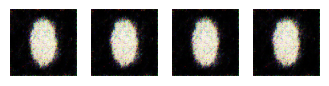

Epoch 51/300 --- Generator Loss: 0.6231 --- Discriminator Loss: 1.4847
Epoch 52/300 --- Generator Loss: 0.6244 --- Discriminator Loss: 1.4829
Epoch 53/300 --- Generator Loss: 0.6291 --- Discriminator Loss: 1.4770
Epoch 54/300 --- Generator Loss: 0.6277 --- Discriminator Loss: 1.4741
Epoch 55/300 --- Generator Loss: 0.6318 --- Discriminator Loss: 1.4722


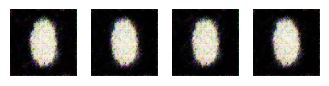

Epoch 56/300 --- Generator Loss: 0.6359 --- Discriminator Loss: 1.4687
Epoch 57/300 --- Generator Loss: 0.6369 --- Discriminator Loss: 1.4659
Epoch 58/300 --- Generator Loss: 0.6422 --- Discriminator Loss: 1.4613
Epoch 59/300 --- Generator Loss: 0.6447 --- Discriminator Loss: 1.4584
Epoch 60/300 --- Generator Loss: 0.6489 --- Discriminator Loss: 1.4555


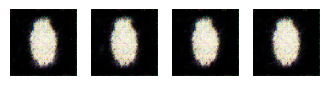

Epoch 61/300 --- Generator Loss: 0.6469 --- Discriminator Loss: 1.4551
Epoch 62/300 --- Generator Loss: 0.6549 --- Discriminator Loss: 1.4493
Epoch 63/300 --- Generator Loss: 0.6521 --- Discriminator Loss: 1.4502
Epoch 64/300 --- Generator Loss: 0.6526 --- Discriminator Loss: 1.4467
Epoch 65/300 --- Generator Loss: 0.6538 --- Discriminator Loss: 1.4420


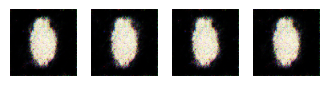

Epoch 66/300 --- Generator Loss: 0.6520 --- Discriminator Loss: 1.4401
Epoch 67/300 --- Generator Loss: 0.6489 --- Discriminator Loss: 1.4427
Epoch 68/300 --- Generator Loss: 0.6480 --- Discriminator Loss: 1.4372
Epoch 69/300 --- Generator Loss: 0.6456 --- Discriminator Loss: 1.4391
Epoch 70/300 --- Generator Loss: 0.6431 --- Discriminator Loss: 1.4378


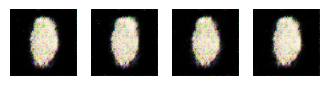

Epoch 71/300 --- Generator Loss: 0.6434 --- Discriminator Loss: 1.4372
Epoch 72/300 --- Generator Loss: 0.6504 --- Discriminator Loss: 1.4325
Epoch 73/300 --- Generator Loss: 0.6547 --- Discriminator Loss: 1.4300
Epoch 74/300 --- Generator Loss: 0.6566 --- Discriminator Loss: 1.4293
Epoch 75/300 --- Generator Loss: 0.6645 --- Discriminator Loss: 1.4276


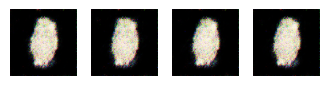

Epoch 76/300 --- Generator Loss: 0.6695 --- Discriminator Loss: 1.4419
Epoch 77/300 --- Generator Loss: 0.6745 --- Discriminator Loss: 1.4523
Epoch 78/300 --- Generator Loss: 0.6762 --- Discriminator Loss: 1.4550
Epoch 79/300 --- Generator Loss: 0.6838 --- Discriminator Loss: 1.4493
Epoch 80/300 --- Generator Loss: 0.6827 --- Discriminator Loss: 1.4458


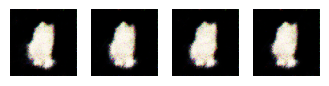

Epoch 81/300 --- Generator Loss: 0.6821 --- Discriminator Loss: 1.4398
Epoch 82/300 --- Generator Loss: 0.6864 --- Discriminator Loss: 1.4320
Epoch 83/300 --- Generator Loss: 0.6919 --- Discriminator Loss: 1.4210
Epoch 84/300 --- Generator Loss: 0.6927 --- Discriminator Loss: 1.4141
Epoch 85/300 --- Generator Loss: 0.6854 --- Discriminator Loss: 1.4090


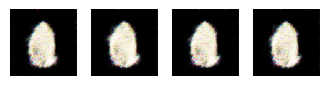

Epoch 86/300 --- Generator Loss: 0.6673 --- Discriminator Loss: 1.4210
Epoch 87/300 --- Generator Loss: 0.6429 --- Discriminator Loss: 1.4386
Epoch 88/300 --- Generator Loss: 0.6319 --- Discriminator Loss: 1.4381
Epoch 89/300 --- Generator Loss: 0.6309 --- Discriminator Loss: 1.4477
Epoch 90/300 --- Generator Loss: 0.6378 --- Discriminator Loss: 1.4615


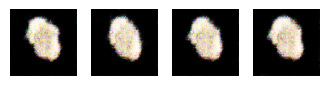

Epoch 91/300 --- Generator Loss: 0.6444 --- Discriminator Loss: 1.4643
Epoch 92/300 --- Generator Loss: 0.6515 --- Discriminator Loss: 1.4541
Epoch 93/300 --- Generator Loss: 0.6568 --- Discriminator Loss: 1.4493
Epoch 94/300 --- Generator Loss: 0.6684 --- Discriminator Loss: 1.4404
Epoch 95/300 --- Generator Loss: 0.6732 --- Discriminator Loss: 1.4339


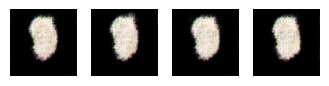

Epoch 96/300 --- Generator Loss: 0.6806 --- Discriminator Loss: 1.4258
Epoch 97/300 --- Generator Loss: 0.6824 --- Discriminator Loss: 1.4204
Epoch 98/300 --- Generator Loss: 0.6822 --- Discriminator Loss: 1.4150
Epoch 99/300 --- Generator Loss: 0.6772 --- Discriminator Loss: 1.4172
Epoch 100/300 --- Generator Loss: 0.6769 --- Discriminator Loss: 1.4123


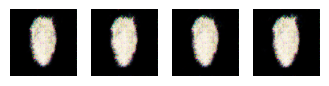

Epoch 101/300 --- Generator Loss: 0.6750 --- Discriminator Loss: 1.4180
Epoch 102/300 --- Generator Loss: 0.6738 --- Discriminator Loss: 1.4283
Epoch 103/300 --- Generator Loss: 0.6794 --- Discriminator Loss: 1.4352
Epoch 104/300 --- Generator Loss: 0.6794 --- Discriminator Loss: 1.4405
Epoch 105/300 --- Generator Loss: 0.6809 --- Discriminator Loss: 1.4413


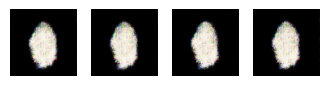

Epoch 106/300 --- Generator Loss: 0.6801 --- Discriminator Loss: 1.4370
Epoch 107/300 --- Generator Loss: 0.6815 --- Discriminator Loss: 1.4299
Epoch 108/300 --- Generator Loss: 0.6789 --- Discriminator Loss: 1.4302
Epoch 109/300 --- Generator Loss: 0.6790 --- Discriminator Loss: 1.4236
Epoch 110/300 --- Generator Loss: 0.6788 --- Discriminator Loss: 1.4203


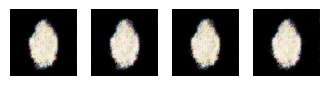

Epoch 111/300 --- Generator Loss: 0.6782 --- Discriminator Loss: 1.4171
Epoch 112/300 --- Generator Loss: 0.6727 --- Discriminator Loss: 1.4139
Epoch 113/300 --- Generator Loss: 0.6731 --- Discriminator Loss: 1.4150
Epoch 114/300 --- Generator Loss: 0.6697 --- Discriminator Loss: 1.4151
Epoch 115/300 --- Generator Loss: 0.6682 --- Discriminator Loss: 1.4133


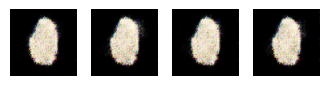

Epoch 116/300 --- Generator Loss: 0.6701 --- Discriminator Loss: 1.4124
Epoch 117/300 --- Generator Loss: 0.6725 --- Discriminator Loss: 1.4100
Epoch 118/300 --- Generator Loss: 0.6736 --- Discriminator Loss: 1.4123
Epoch 119/300 --- Generator Loss: 0.6772 --- Discriminator Loss: 1.4184
Epoch 120/300 --- Generator Loss: 0.6758 --- Discriminator Loss: 1.4222


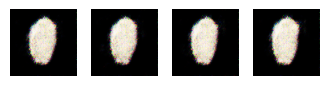

Epoch 121/300 --- Generator Loss: 0.6792 --- Discriminator Loss: 1.4181
Epoch 122/300 --- Generator Loss: 0.6809 --- Discriminator Loss: 1.4204
Epoch 123/300 --- Generator Loss: 0.6862 --- Discriminator Loss: 1.4175
Epoch 124/300 --- Generator Loss: 0.6869 --- Discriminator Loss: 1.4145
Epoch 125/300 --- Generator Loss: 0.6902 --- Discriminator Loss: 1.4108


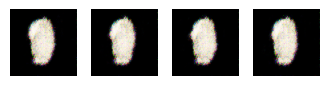

Epoch 126/300 --- Generator Loss: 0.6882 --- Discriminator Loss: 1.4093
Epoch 127/300 --- Generator Loss: 0.6858 --- Discriminator Loss: 1.4100
Epoch 128/300 --- Generator Loss: 0.6790 --- Discriminator Loss: 1.4129
Epoch 129/300 --- Generator Loss: 0.6793 --- Discriminator Loss: 1.4121
Epoch 130/300 --- Generator Loss: 0.6764 --- Discriminator Loss: 1.4142


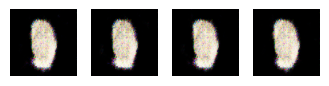

Epoch 131/300 --- Generator Loss: 0.6783 --- Discriminator Loss: 1.4131
Epoch 132/300 --- Generator Loss: 0.6759 --- Discriminator Loss: 1.4138
Epoch 133/300 --- Generator Loss: 0.6729 --- Discriminator Loss: 1.4139
Epoch 134/300 --- Generator Loss: 0.6652 --- Discriminator Loss: 1.4130
Epoch 135/300 --- Generator Loss: 0.6679 --- Discriminator Loss: 1.4068


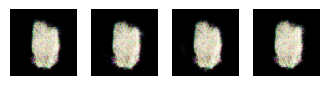

Epoch 136/300 --- Generator Loss: 0.6716 --- Discriminator Loss: 1.4053
Epoch 137/300 --- Generator Loss: 0.6776 --- Discriminator Loss: 1.4024
Epoch 138/300 --- Generator Loss: 0.6781 --- Discriminator Loss: 1.3998
Epoch 139/300 --- Generator Loss: 0.6812 --- Discriminator Loss: 1.3974
Epoch 140/300 --- Generator Loss: 0.6811 --- Discriminator Loss: 1.3965


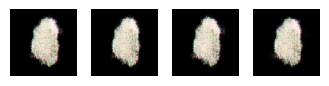

Epoch 141/300 --- Generator Loss: 0.6785 --- Discriminator Loss: 1.4019
Epoch 142/300 --- Generator Loss: 0.6782 --- Discriminator Loss: 1.4224
Epoch 143/300 --- Generator Loss: 0.6771 --- Discriminator Loss: 1.4238
Epoch 144/300 --- Generator Loss: 0.6742 --- Discriminator Loss: 1.4239
Epoch 145/300 --- Generator Loss: 0.6789 --- Discriminator Loss: 1.4160


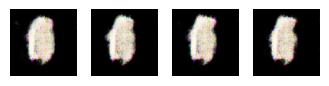

Epoch 146/300 --- Generator Loss: 0.6774 --- Discriminator Loss: 1.4143
Epoch 147/300 --- Generator Loss: 0.6813 --- Discriminator Loss: 1.4070
Epoch 148/300 --- Generator Loss: 0.6785 --- Discriminator Loss: 1.4070
Epoch 149/300 --- Generator Loss: 0.6780 --- Discriminator Loss: 1.4070
Epoch 150/300 --- Generator Loss: 0.6789 --- Discriminator Loss: 1.4073


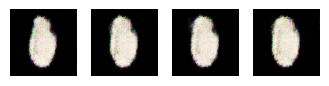

Epoch 151/300 --- Generator Loss: 0.6777 --- Discriminator Loss: 1.4094
Epoch 152/300 --- Generator Loss: 0.6800 --- Discriminator Loss: 1.4095
Epoch 153/300 --- Generator Loss: 0.6807 --- Discriminator Loss: 1.4107
Epoch 154/300 --- Generator Loss: 0.6814 --- Discriminator Loss: 1.4083
Epoch 155/300 --- Generator Loss: 0.6845 --- Discriminator Loss: 1.4109


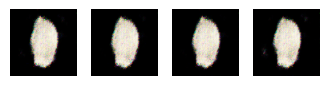

Epoch 156/300 --- Generator Loss: 0.6842 --- Discriminator Loss: 1.4110
Epoch 157/300 --- Generator Loss: 0.6876 --- Discriminator Loss: 1.4083
Epoch 158/300 --- Generator Loss: 0.6874 --- Discriminator Loss: 1.4088
Epoch 159/300 --- Generator Loss: 0.6896 --- Discriminator Loss: 1.4035
Epoch 160/300 --- Generator Loss: 0.6928 --- Discriminator Loss: 1.4014


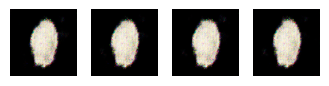

Epoch 161/300 --- Generator Loss: 0.6909 --- Discriminator Loss: 1.3990
Epoch 162/300 --- Generator Loss: 0.6905 --- Discriminator Loss: 1.3999
Epoch 163/300 --- Generator Loss: 0.6920 --- Discriminator Loss: 1.3985
Epoch 164/300 --- Generator Loss: 0.6882 --- Discriminator Loss: 1.3960
Epoch 165/300 --- Generator Loss: 0.6843 --- Discriminator Loss: 1.4010


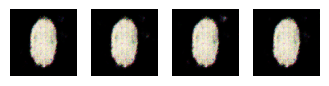

Epoch 166/300 --- Generator Loss: 0.6833 --- Discriminator Loss: 1.4017
Epoch 167/300 --- Generator Loss: 0.6825 --- Discriminator Loss: 1.4017
Epoch 168/300 --- Generator Loss: 0.6778 --- Discriminator Loss: 1.4049
Epoch 169/300 --- Generator Loss: 0.6807 --- Discriminator Loss: 1.3986
Epoch 170/300 --- Generator Loss: 0.6816 --- Discriminator Loss: 1.3981


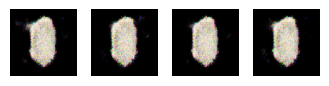

Epoch 171/300 --- Generator Loss: 0.6793 --- Discriminator Loss: 1.3976
Epoch 172/300 --- Generator Loss: 0.6804 --- Discriminator Loss: 1.3975
Epoch 173/300 --- Generator Loss: 0.6817 --- Discriminator Loss: 1.3965
Epoch 174/300 --- Generator Loss: 0.6828 --- Discriminator Loss: 1.3944
Epoch 175/300 --- Generator Loss: 0.6864 --- Discriminator Loss: 1.3936


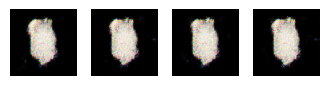

Epoch 176/300 --- Generator Loss: 0.6900 --- Discriminator Loss: 1.3901
Epoch 177/300 --- Generator Loss: 0.6931 --- Discriminator Loss: 1.3937
Epoch 178/300 --- Generator Loss: 0.6940 --- Discriminator Loss: 1.3957
Epoch 179/300 --- Generator Loss: 0.6852 --- Discriminator Loss: 1.4058
Epoch 180/300 --- Generator Loss: 0.6816 --- Discriminator Loss: 1.4102


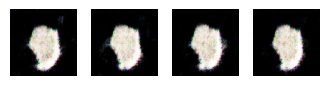

Epoch 181/300 --- Generator Loss: 0.6808 --- Discriminator Loss: 1.4050
Epoch 182/300 --- Generator Loss: 0.6761 --- Discriminator Loss: 1.4032
Epoch 183/300 --- Generator Loss: 0.6713 --- Discriminator Loss: 1.4027
Epoch 184/300 --- Generator Loss: 0.6740 --- Discriminator Loss: 1.3993
Epoch 185/300 --- Generator Loss: 0.6787 --- Discriminator Loss: 1.3958


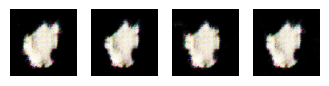

Epoch 186/300 --- Generator Loss: 0.6759 --- Discriminator Loss: 1.4000
Epoch 187/300 --- Generator Loss: 0.6707 --- Discriminator Loss: 1.4062
Epoch 188/300 --- Generator Loss: 0.6789 --- Discriminator Loss: 1.4070
Epoch 189/300 --- Generator Loss: 0.6950 --- Discriminator Loss: 1.4079
Epoch 190/300 --- Generator Loss: 0.6984 --- Discriminator Loss: 1.4037


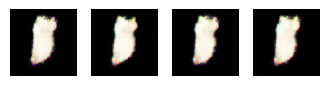

Epoch 191/300 --- Generator Loss: 0.7037 --- Discriminator Loss: 1.3980
Epoch 192/300 --- Generator Loss: 0.6876 --- Discriminator Loss: 1.4029
Epoch 193/300 --- Generator Loss: 0.6812 --- Discriminator Loss: 1.4040
Epoch 194/300 --- Generator Loss: 0.6802 --- Discriminator Loss: 1.4045
Epoch 195/300 --- Generator Loss: 0.6790 --- Discriminator Loss: 1.4017


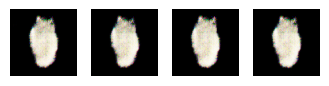

Epoch 196/300 --- Generator Loss: 0.6792 --- Discriminator Loss: 1.4012
Epoch 197/300 --- Generator Loss: 0.6832 --- Discriminator Loss: 1.4001
Epoch 198/300 --- Generator Loss: 0.6818 --- Discriminator Loss: 1.3989
Epoch 199/300 --- Generator Loss: 0.6860 --- Discriminator Loss: 1.3999
Epoch 200/300 --- Generator Loss: 0.6894 --- Discriminator Loss: 1.3985


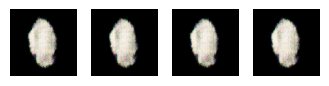

Epoch 201/300 --- Generator Loss: 0.6934 --- Discriminator Loss: 1.3977
Epoch 202/300 --- Generator Loss: 0.6971 --- Discriminator Loss: 1.3974
Epoch 203/300 --- Generator Loss: 0.6967 --- Discriminator Loss: 1.3936
Epoch 204/300 --- Generator Loss: 0.6976 --- Discriminator Loss: 1.3937
Epoch 205/300 --- Generator Loss: 0.6959 --- Discriminator Loss: 1.3953


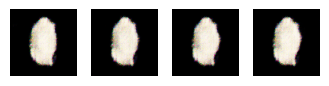

Epoch 206/300 --- Generator Loss: 0.6878 --- Discriminator Loss: 1.3988
Epoch 207/300 --- Generator Loss: 0.6753 --- Discriminator Loss: 1.4016
Epoch 208/300 --- Generator Loss: 0.6702 --- Discriminator Loss: 1.4001
Epoch 209/300 --- Generator Loss: 0.6752 --- Discriminator Loss: 1.3935
Epoch 210/300 --- Generator Loss: 0.6742 --- Discriminator Loss: 1.3921


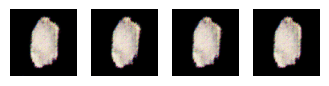

Epoch 211/300 --- Generator Loss: 0.6820 --- Discriminator Loss: 1.3914
Epoch 212/300 --- Generator Loss: 0.6918 --- Discriminator Loss: 1.3955
Epoch 213/300 --- Generator Loss: 0.6952 --- Discriminator Loss: 1.3973
Epoch 214/300 --- Generator Loss: 0.6968 --- Discriminator Loss: 1.3940
Epoch 215/300 --- Generator Loss: 0.6971 --- Discriminator Loss: 1.3902


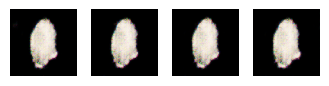

Epoch 216/300 --- Generator Loss: 0.6987 --- Discriminator Loss: 1.3889
Epoch 217/300 --- Generator Loss: 0.6942 --- Discriminator Loss: 1.3894
Epoch 218/300 --- Generator Loss: 0.6745 --- Discriminator Loss: 1.4019
Epoch 219/300 --- Generator Loss: 0.6630 --- Discriminator Loss: 1.4061
Epoch 220/300 --- Generator Loss: 0.6642 --- Discriminator Loss: 1.3967


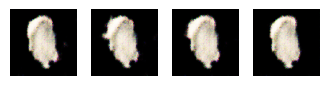

Epoch 221/300 --- Generator Loss: 0.6765 --- Discriminator Loss: 1.3949
Epoch 222/300 --- Generator Loss: 0.6844 --- Discriminator Loss: 1.3968
Epoch 223/300 --- Generator Loss: 0.6978 --- Discriminator Loss: 1.4025
Epoch 224/300 --- Generator Loss: 0.6960 --- Discriminator Loss: 1.3986
Epoch 225/300 --- Generator Loss: 0.6994 --- Discriminator Loss: 1.3967


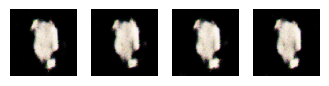

Epoch 226/300 --- Generator Loss: 0.7048 --- Discriminator Loss: 1.3921
Epoch 227/300 --- Generator Loss: 0.6938 --- Discriminator Loss: 1.3898
Epoch 228/300 --- Generator Loss: 0.6838 --- Discriminator Loss: 1.3932
Epoch 229/300 --- Generator Loss: 0.6798 --- Discriminator Loss: 1.4225
Epoch 230/300 --- Generator Loss: 0.7118 --- Discriminator Loss: 1.4091


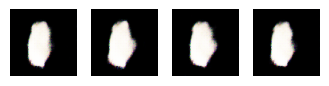

Epoch 231/300 --- Generator Loss: 0.7065 --- Discriminator Loss: 1.3964
Epoch 232/300 --- Generator Loss: 0.7023 --- Discriminator Loss: 1.3876
Epoch 233/300 --- Generator Loss: 0.6934 --- Discriminator Loss: 1.3920
Epoch 234/300 --- Generator Loss: 0.7001 --- Discriminator Loss: 1.3995
Epoch 235/300 --- Generator Loss: 0.6968 --- Discriminator Loss: 1.4000


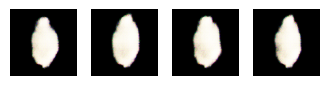

Epoch 236/300 --- Generator Loss: 0.6802 --- Discriminator Loss: 1.4089
Epoch 237/300 --- Generator Loss: 0.6758 --- Discriminator Loss: 1.3942
Epoch 238/300 --- Generator Loss: 0.6706 --- Discriminator Loss: 1.3989
Epoch 239/300 --- Generator Loss: 0.6905 --- Discriminator Loss: 1.3953
Epoch 240/300 --- Generator Loss: 0.6835 --- Discriminator Loss: 1.3972


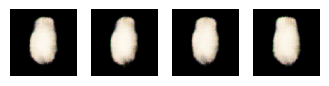

Epoch 241/300 --- Generator Loss: 0.6859 --- Discriminator Loss: 1.3965
Epoch 242/300 --- Generator Loss: 0.6896 --- Discriminator Loss: 1.3948
Epoch 243/300 --- Generator Loss: 0.6915 --- Discriminator Loss: 1.3955
Epoch 244/300 --- Generator Loss: 0.6925 --- Discriminator Loss: 1.3950
Epoch 245/300 --- Generator Loss: 0.6924 --- Discriminator Loss: 1.3951


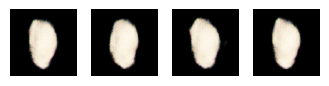

Epoch 246/300 --- Generator Loss: 0.6865 --- Discriminator Loss: 1.3949
Epoch 247/300 --- Generator Loss: 0.6876 --- Discriminator Loss: 1.3958
Epoch 248/300 --- Generator Loss: 0.6931 --- Discriminator Loss: 1.3950
Epoch 249/300 --- Generator Loss: 0.6888 --- Discriminator Loss: 1.3955
Epoch 250/300 --- Generator Loss: 0.6916 --- Discriminator Loss: 1.3865


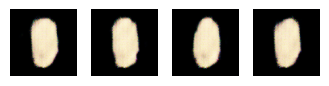

Epoch 251/300 --- Generator Loss: 0.6859 --- Discriminator Loss: 1.3995
Epoch 252/300 --- Generator Loss: 0.7115 --- Discriminator Loss: 1.3928
Epoch 253/300 --- Generator Loss: 0.7022 --- Discriminator Loss: 1.3945
Epoch 254/300 --- Generator Loss: 0.6917 --- Discriminator Loss: 1.3993
Epoch 255/300 --- Generator Loss: 0.6890 --- Discriminator Loss: 1.3886


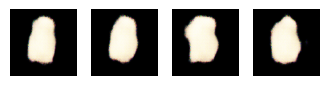

Epoch 256/300 --- Generator Loss: 0.6863 --- Discriminator Loss: 1.3879
Epoch 257/300 --- Generator Loss: 0.6913 --- Discriminator Loss: 1.4040
Epoch 258/300 --- Generator Loss: 0.7240 --- Discriminator Loss: 1.3921
Epoch 259/300 --- Generator Loss: 0.7005 --- Discriminator Loss: 1.3923
Epoch 260/300 --- Generator Loss: 0.6871 --- Discriminator Loss: 1.3944


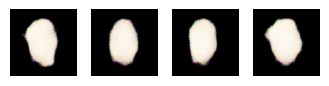

Epoch 261/300 --- Generator Loss: 0.6835 --- Discriminator Loss: 1.3899
Epoch 262/300 --- Generator Loss: 0.6787 --- Discriminator Loss: 1.3923
Epoch 263/300 --- Generator Loss: 0.6752 --- Discriminator Loss: 1.4001
Epoch 264/300 --- Generator Loss: 0.6795 --- Discriminator Loss: 1.3964
Epoch 265/300 --- Generator Loss: 0.6782 --- Discriminator Loss: 1.3991


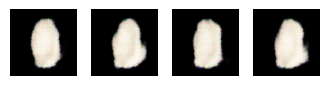

Epoch 266/300 --- Generator Loss: 0.6796 --- Discriminator Loss: 1.3910
Epoch 267/300 --- Generator Loss: 0.6726 --- Discriminator Loss: 1.3922
Epoch 268/300 --- Generator Loss: 0.6782 --- Discriminator Loss: 1.3943
Epoch 269/300 --- Generator Loss: 0.6897 --- Discriminator Loss: 1.3924
Epoch 270/300 --- Generator Loss: 0.6917 --- Discriminator Loss: 1.3952


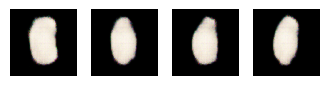

Epoch 271/300 --- Generator Loss: 0.6925 --- Discriminator Loss: 1.3965
Epoch 272/300 --- Generator Loss: 0.6938 --- Discriminator Loss: 1.3948
Epoch 273/300 --- Generator Loss: 0.6947 --- Discriminator Loss: 1.3957
Epoch 274/300 --- Generator Loss: 0.6982 --- Discriminator Loss: 1.3966
Epoch 275/300 --- Generator Loss: 0.6979 --- Discriminator Loss: 1.3909


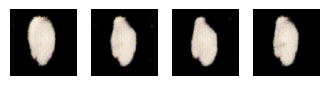

Epoch 276/300 --- Generator Loss: 0.6918 --- Discriminator Loss: 1.3941
Epoch 277/300 --- Generator Loss: 0.6861 --- Discriminator Loss: 1.3941
Epoch 278/300 --- Generator Loss: 0.6847 --- Discriminator Loss: 1.3891
Epoch 279/300 --- Generator Loss: 0.6809 --- Discriminator Loss: 1.3966
Epoch 280/300 --- Generator Loss: 0.6901 --- Discriminator Loss: 1.3947


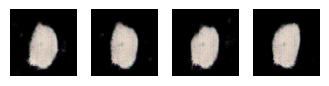

Epoch 281/300 --- Generator Loss: 0.6926 --- Discriminator Loss: 1.3917
Epoch 282/300 --- Generator Loss: 0.6859 --- Discriminator Loss: 1.3959
Epoch 283/300 --- Generator Loss: 0.6854 --- Discriminator Loss: 1.3913
Epoch 284/300 --- Generator Loss: 0.6851 --- Discriminator Loss: 1.3904
Epoch 285/300 --- Generator Loss: 0.6862 --- Discriminator Loss: 1.3971


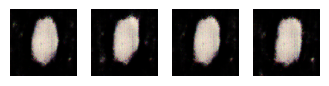

Epoch 286/300 --- Generator Loss: 0.7016 --- Discriminator Loss: 1.3920
Epoch 287/300 --- Generator Loss: 0.6935 --- Discriminator Loss: 1.3951
Epoch 288/300 --- Generator Loss: 0.6903 --- Discriminator Loss: 1.3936
Epoch 289/300 --- Generator Loss: 0.6925 --- Discriminator Loss: 1.3917
Epoch 290/300 --- Generator Loss: 0.6920 --- Discriminator Loss: 1.3931


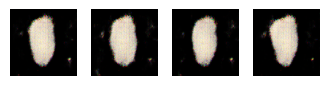

Epoch 291/300 --- Generator Loss: 0.6937 --- Discriminator Loss: 1.3964
Epoch 292/300 --- Generator Loss: 0.6911 --- Discriminator Loss: 1.3943
Epoch 293/300 --- Generator Loss: 0.6852 --- Discriminator Loss: 1.3969
Epoch 294/300 --- Generator Loss: 0.6858 --- Discriminator Loss: 1.3925
Epoch 295/300 --- Generator Loss: 0.6808 --- Discriminator Loss: 1.3901


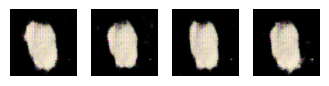

Epoch 296/300 --- Generator Loss: 0.6774 --- Discriminator Loss: 1.3955
Epoch 297/300 --- Generator Loss: 0.6859 --- Discriminator Loss: 1.3910
Epoch 298/300 --- Generator Loss: 0.6854 --- Discriminator Loss: 1.3930
Epoch 299/300 --- Generator Loss: 0.6809 --- Discriminator Loss: 1.3920
Epoch 300/300 --- Generator Loss: 0.6804 --- Discriminator Loss: 1.3900


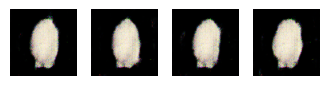

In [ ]:
discriminator_mod = build_discriminator_mod()
generator_mod = build_generator_mod()

generator_mod_optimizer = Adam(1e-4)
discriminator_mod_optimizer = Adam(1e-5) 

for epoch in range(nEpoch):
    gen_losses = []
    disc_losses = []
    
    for image_batch in train_dataset:
        noise = tf.random.normal([image_batch.shape[0], 100])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator_mod(noise, training=True)

            real_output = discriminator_mod(image_batch, training=True)
            fake_output = discriminator_mod(generated_images, training=True)

            g_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(g_loss, generator_mod.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_mod.trainable_variables)

        generator_mod_optimizer.apply_gradients(zip(gradients_of_generator, generator_mod.trainable_variables))
        discriminator_mod_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_mod.trainable_variables))
        
        gen_losses.append(g_loss)
        disc_losses.append(disc_loss)
    
    avg_gen_loss = tf.reduce_mean(gen_losses)
    avg_disc_loss = tf.reduce_mean(disc_losses)
    
    print(f"Epoch {epoch+1}/{nEpoch} --- Generator Loss: {avg_gen_loss:.4f} --- Discriminator Loss: {avg_disc_loss:.4f}")

    if (epoch + 1) % 5 == 0:
        seed = tf.random.normal([4, 100])
        predictions = generator_mod(seed, training=False)
        fig = plt.figure(figsize=(4,4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
            plt.axis('off')
        plt.show()

# Evaluasi

In [42]:
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Resize ke 299x299 dan preprocess
    real_images = tf.image.resize(real_images, (299, 299))
    gen_images = tf.image.resize(generated_images, (299, 299))

    real_images = preprocess_input(real_images)
    gen_images = preprocess_input(generated_images)

    # Ambil fitur dari InceptionV3
    act1 = model.predict(real_images, verbose=0)
    act2 = model.predict(gen_images, verbose=0)

    # Hitung statistik mean & cov
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Hitung FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean): covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


In [40]:
def unscale(images):
    return (images + 1.0) / 2.0

def evaluate_fid(generator, real_images, num_samples=1000):
    noise = np.random.normal(0, 1, (num_samples, noise_dim))
    gen_images = generator.predict(noise, verbose=0)
    
    real_subset = real_images[:num_samples]
    fid = calculate_fid(unscale(real_subset), unscale(gen_images))
    return fid

In [45]:
fid_baseline = evaluate_fid(generator, X_test)
print(f"FID Baseline: {fid_baseline:.2f}")

FID Baseline: 455.99


In [46]:
fid_mod = evaluate_fid(generator_mod, X_test)
print(f"FID Modifikasi: {fid_mod:.2f}")

FID Modifikasi: 525.73


FID (Fréchet Inception Distance) adalah metrik evaluasi yang digunakan untuk mengukur kualitas gambar yang dihasilkan oleh model generatif seperti GAN. 
FID membandingkan:
- Distribusi fitur dari gambar asli (real)
- Dengan distribusi fitur dari gambar hasil generasi (fake)

FID Baseline (455.99) → Model generator awal

FID Modifikasi (525.73) → Model generator setelah dimodifikasi

Nilai FID meningkat setelah modifikasi: 455.99 → 525.73. Ini berarti gambar dari model modifikasi justru lebih jauh kualitasnya dari data asli dibanding model awal.
Modifikasi tersebut kurang berhasil memperbaiki kualitas gambar, dan justru menurunkan performa dalam hal kemiripan statistik distribusi.

Kedepannya untuk memperbaiki ini kita dapat perbaiki arsitektur generator (pakai batch normalization dan aktivasi yang tepat), tambahkan dropout di discriminator, gunakan loss function yang lebih stabil, lakukan augmentasi data, dan evaluasi FID secara rutin selama training.